Below is the script on how the frag.gz and .res files were combined and filtered in order to determine how many of the scaffolds carrying ARGs had any flanks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import itertools
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

def figure_saver(fig, prefix, contexts=['paper'], formats=['.png', '.pdf', '.tiff']):
    
    for context in contexts:
        sns.set_context(context)
        for fformat in formats:
            fname = f"{prefix}_{context}{fformat}"
            fig.savefig(fname,  bbox_inches = "tight")
    
    sns.set_context('paper')

def get_cmap(labels, name='viridis'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    cmap = plt.get_cmap(name, len(labels))#.colors
    
    return {l: cmap(i) for i, l in enumerate(labels)}

def flank_hist(ax, df, palette, x=None, y=None):
    
    if x is not None:
        sns.histplot(
            data = df.query(f"{x} > 0"),
            x = x,
            hue= 'tool',
            multiple='dodge',
            bins=25,
            shrink=.8,
            log_scale=True,
            palette=palette,
            stat='count',
            alpha=.75,
            ax=ax
            )

        if (df[x] == 0).any(): 
            ax.set_xscale('symlog')

            sns.histplot(
                data = df.query(f"{x} == 0"),
                x = x,
                hue= 'tool',
                multiple='dodge',
                bins=1,
                shrink=.4,
                palette=palette,
                stat='count',
                alpha=.75,
                ax = ax,
            )
    elif y is not None:
        sns.histplot(
            data = df.query(f"{y} > 0"),
            y = y,
            hue= 'tool',
            multiple='dodge',
            bins=30,
            shrink=.8,
            log_scale=True,
            palette=palette,
            stat='count',
            alpha=.75,
            ax=ax
            )

        if (df[y] == 0).any(): 
            ax.set_yscale('symlog')

            sns.histplot(
                data = df.query(f"{y} == 0"),
                y = y,
                hue= 'tool',
                multiple='dodge',
                bins=1,
                shrink=.4,
                palette=palette,
                stat='count',
                alpha=.75,
                ax = ax,
            )

In [24]:
df = pd.read_csv('data/kma_filtered.csv', header=None)
df.drop_duplicates(inplace=True)
df.columns = df.iloc[0]
df.drop(index=0, inplace=True)
df['tool'] = df['sample'].str.startswith('DTU').replace({True: 'SPAdes', False: 'ARGextender'})


dfGS = pd.read_excel('data/41467_2022_34312_MOESM3_ESM.xlsx')
df = df.merge(dfGS[['new_complete_name','ena_run_acc']], left_on='sample', right_on='new_complete_name', how='left')
df['ena_run_acc'].fillna(df['sample'], inplace=True)
df.drop(columns=['sample', 'new_complete_name'], inplace=True)
df.dropna(inplace=True)

df = df.query("ena_run_acc != 'test'")
df.flank_bp = df.flank_bp.astype(int)

In [25]:
palette = {
    category: sns.color_palette('tab10')[i] for i, category in enumerate(['SPAdes', 'ARGextender'])
}#get_cmap(labels=['SPAdes', 'ARGextender'], name='tab10')

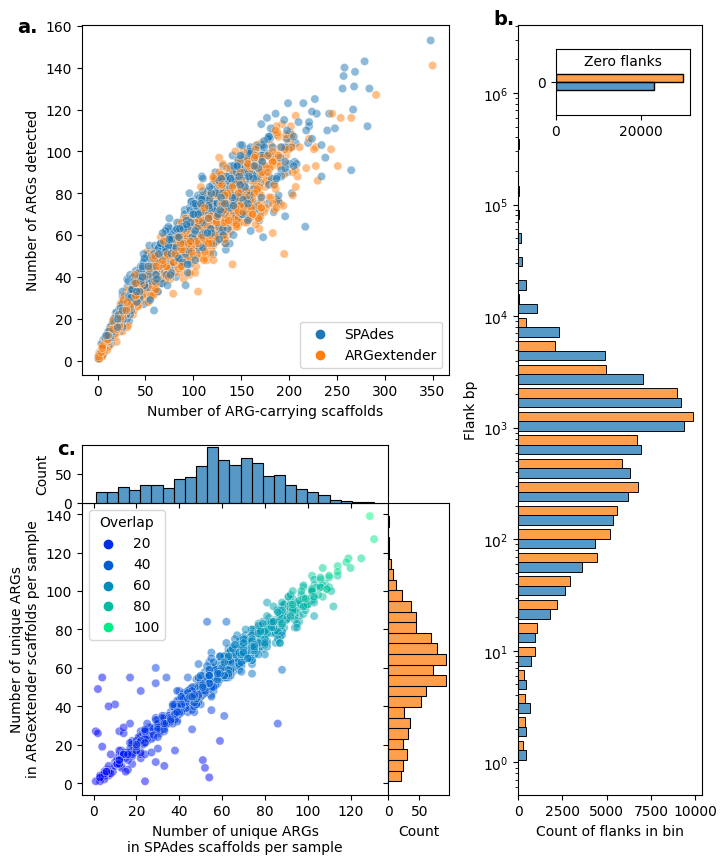

In [26]:
fig = plt.figure(figsize=(8,10))
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[1, .5], wspace=0.25)#, height_ratios=[.7, 1])

gs1 = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=2, width_ratios=[1, .2], height_ratios=[.2, 1], wspace=0.0, hspace=0.0, subplot_spec=gs[1,0])
gs2 = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=3, height_ratios=[0.0005,.1, 1], width_ratios=[0.01,0.05, 0.0005], subplot_spec=gs[:, 1], hspace=0.1)



ax_scatter = fig.add_subplot(gs[0,0])

ax_big = fig.add_subplot(gs1[1,0])
ax_barright = fig.add_subplot(gs1[1,1], sharey=ax_big)
ax_bartop = fig.add_subplot(gs1[0,0], sharex=ax_big)

ax_histBig = fig.add_subplot(gs[:,1])
ax_histSmall = fig.add_subplot(gs2[1,1])

sns.scatterplot(
    data = df.groupby(['ena_run_acc', 'tool']).agg({'sseqid': 'nunique', 'qseqid': 'nunique'}).pivot_table(index=['ena_run_acc', 'tool'], values=['qseqid', 'sseqid']).reset_index(),    
    x = 'qseqid',
    y = 'sseqid',
    hue = 'tool',
    palette=palette,
    alpha = .5,
    ax = ax_scatter
)

uniqueRunSets = pd.DataFrame(df.query("flank_bp > 0").groupby(['ena_run_acc', 'tool'])['sseqid'].unique().apply(set)).reset_index().pivot(index='ena_run_acc', columns='tool', values='sseqid')
uniqueRunSets.dropna(inplace=True)
uniqueRunSets['ARGextender_count'] = uniqueRunSets['ARGextender'].apply(len)
uniqueRunSets['SPAdes_count'] = uniqueRunSets['SPAdes'].apply(len)
uniqueRunSets['overlap'] = uniqueRunSets.apply(
    lambda x: x['ARGextender'].intersection(x['SPAdes']) ,
    axis = 1
)
uniqueRunSets['overlap_count'] = uniqueRunSets['overlap'].apply(len)


sns.scatterplot(
    data = uniqueRunSets,
    x = 'SPAdes_count',
    y = 'ARGextender_count',
    hue = 'overlap_count',
    ax = ax_big,
    palette='winter',
    alpha = .5,
)

sns.histplot(
    data = uniqueRunSets,
    x = 'SPAdes_count',
    ax = ax_bartop,
    color=palette['SPAdes'],
    bins=25
)

sns.histplot(
    data = uniqueRunSets,
    y = 'ARGextender_count',
    ax = ax_barright,
    color=palette['ARGextender'],
    bins=25
)

flank_hist(
    ax=ax_histBig,
    df = df.query("flank_bp > 0"),
    y='flank_bp',
    palette=palette
    
)

sns.histplot(
    ax=ax_histSmall,
    data = df.query("flank_bp == 0"),
    y='flank_bp',
    palette=palette,
    hue = 'tool',
    multiple='dodge',
    shrink=0.1,
    bins=1
)
ax_histSmall.set_ylim(-.2,.2)
ax_histSmall.set_yticks([0])

# set ax labels and titles
ax_scatter.set_xlabel('Number of ARG-carrying scaffolds')
ax_scatter.set_ylabel('Number of ARGs detected')
ax_scatter.legend(loc='lower right')

plt.setp(ax_barright.get_yticklabels(), visible=False)
plt.setp(ax_bartop.get_xticklabels(), visible=False)

ax_bartop.set_xlabel('')
ax_bartop.set_ylabel('Count')
ax_barright.set_ylabel('')
ax_barright.set_xlabel('Count')

ax_big.set_xlabel('Number of unique ARGs\nin SPAdes scaffolds per sample')
ax_big.set_ylabel('Number of unique ARGs\nin ARGextender scaffolds per sample')
ax_big.legend(title='Overlap')

ax_histBig.get_legend().remove()
ax_histSmall.set_xlabel('')
ax_histBig.set_ylabel('Flank bp')
ax_histBig.set_xlabel('Count of flanks in bin')
ax_histSmall.set_ylabel('')
ax_histSmall.get_legend().remove()
ax_histSmall.text(.5,.75,'Zero flanks', horizontalalignment='center', transform=ax_histSmall.transAxes, fontsize=10)

ax_scatter.text(-0.12, 1.02, 'a.', transform=ax_scatter.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
ax_histBig.text(-0.02, 1.02, 'b.', transform=ax_histBig.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
ax_bartop.text(-0.02, 1.1, 'c.', transform=ax_bartop.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

figure_saver(fig=fig, prefix='figures/flank_comparisons')

# Some numbers for main text

Average number of ARGs and ARG scaffolds per method

In [27]:
df.groupby(['ena_run_acc', 'tool']).agg({'sseqid': 'nunique', 'qseqid': 'nunique'}).pivot_table(index=['ena_run_acc', 'tool'], values=['qseqid', 'sseqid']).reset_index(level=1).groupby('tool').describe().round()


qseqid                                              sseqid        \
             count   mean   std  min   25%    50%    75%    max  count  mean   
tool                                                                           
ARGextender  931.0  101.0  55.0  1.0  62.0  104.0  140.0  350.0  931.0  57.0   
SPAdes       980.0   95.0  57.0  1.0  52.0   95.0  133.0  348.0  980.0  58.0   

                                                 
              std  min   25%   50%   75%    max  
tool                                             
ARGextender  26.0  1.0  42.0  59.0  74.0  141.0  
SPAdes       28.0  1.0  40.0  59.0  75.0  153.0